best l2 for 1 gauss functions: 0.19476896471064525
best l2 for 2 gauss functions: 0.07891762124834933
best l2 for 3 gauss functions: 0.033836979516627834

best parameters:
x0: 3.2622e+02; d: 1.2015e+01, A: 1.4875e-03, fraction: 6.8%
x0: 3.7158e+02; d: 1.7708e+01, A: 1.1292e-02, fraction: 76.2%
x0: 3.9190e+02; d: 5.9614e+00, A: 7.4729e-03, fraction: 17.0%


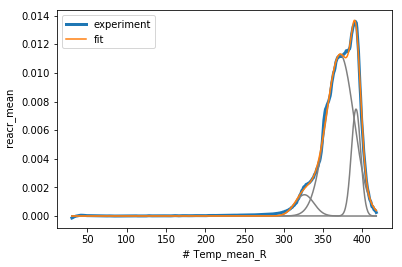

In [9]:
import numpy as np
import pandas as pd
import scipy.optimize
import matplotlib.pyplot as plt

############
## PARAMETER

# input file name
filename = 'PMMA_kompakt_40K.csv'
# x-y-labels
data_x_label = '# Temp_mean_R'
data_y_label = ' reacr_mean'
# skip every point, to increase evaluation
skip_points = 1

# relative minimal y value, used for x-range detection
relative_ymin = 0.0

# number of random guess passes
n_passes = 20
# maximal number of gaussians used for optimisation
n_gausses = 3
# threshold to stop the addition of gaussians
l2_lim = 0.02

## END OF PARAMETER
###################

data = pd.read_csv(filename, header=0)

x = data[data_x_label].values
y = data[data_y_label].values

ymax = np.max(y)
ixmin = np.where(y>relative_ymin*ymax)[0][0]
ixmax = np.where(y>relative_ymin*ymax)[0][-1]

x_scaled = x[ixmin:ixmax:skip_points]
y_scaled = y[ixmin:ixmax:skip_points] / ymax

xmin = x_scaled[0]
xmax = x_scaled[-1]

x_scaled = (x_scaled - xmin) / (xmax - xmin)

# 1: x0
# 2: d
# 3: A
def guess_gauss_parameter():
    r = np.random.rand(3)
    x0 = r[0]
    d = 0.1*r[1]
    A = 1.0
    return x0, d, A

def gauss_function(x, p):
    x0 = p[0]
    d = p[1]
    A = p[2]
    return A*np.exp(-((x-x0)**2)/(2*d**2))

def cost_function(p,x,y):
    delta = np.copy(y)
    l2 = 0
    for i in range(len(p)//3):
        x0 = p[3*i+0]
        d0 = p[3*i+1]
        A0 = p[3*i+2]
        delta -= gauss_function(x,[x0,d0,A0])
        if A0 > 1.0:
            l2 += (A0 - 1.0)**2
        if A0 < 0.01:
            l2 += (100*(0.01-A0))**2
        if d0 < 0.01:
            l2 += (10*(0.01-d0))**2
    l2 += np.sqrt(np.sum(delta**2)) / len(x)
    return l2


l2_0 = np.sqrt(np.sum(y_scaled**2)) / len(y_scaled)

res_l2 = None
res_p = []
res_g = 0

for ig in range(1, n_gausses+1):
    res_g += 1
    res_l2 = 1e10
    for ip in range(n_passes):

        p0 = []
        for g in range(ig):
            p0.extend(guess_gauss_parameter())

        res = scipy.optimize.minimize(cost_function,
                                      np.array(p0),
                                      method='BFGS',
                                      args=(x_scaled,y_scaled),
                                      options={'gtol':1e-7, 'maxiter':500,
                                               'eps':1e-8},
                                      tol=1e-8)
        l2 = cost_function(res.x, x_scaled, y_scaled) / l2_0
        if res_l2 > l2:
            res_l2 = l2
            res_p = res.x

    print("best l2 for {} gauss functions: {}".format(ig, res_l2))
    if res_l2 < l2_lim:
        print("smaller than l2 limit of {} -> break".format(l2_lim))
        break

# rescale xs, ds, As
for ig in range(res_g):
    dx = xmax - xmin
    res_p[3*ig + 0] *= dx
    res_p[3*ig + 0] += xmin
    res_p[3*ig + 1] *= dx
    res_p[3*ig + 2] *= ymax

plt.plot(x, y, label='experiment', linewidth=3)

total_integral = 0
for ig in range(res_g):
    x0 = res_p[3 * ig + 0]
    d = res_p[3 * ig + 1]
    A = res_p[3 * ig + 2]
    total_integral += A * np.sqrt(2*np.pi*d**2)

print("\nbest parameters:")
for ig in range(res_g):
    x0 = res_p[3 * ig + 0]
    d = res_p[3 * ig + 1]
    A = res_p[3 * ig + 2]
    integral_fraction = 100*A * np.sqrt(2*np.pi*d**2) / total_integral
    print("x0: {:10.4e}; d: {:10.4e}, A: {:10.4e}, fraction: {:03.1f}%".format(x0, d, A, integral_fraction))

y_fit = np.zeros_like(x)
for ig in range(res_g):
    loc_y = gauss_function(x, res_p[3*ig:3*ig+3])
    y_fit += loc_y
    plt.plot(x, loc_y, color='grey')
plt.plot(x, y_fit, label='fit')

plt.xlabel(data_x_label)
plt.ylabel(data_y_label)
plt.legend()
plt.show()

# print(res)
#
# xdef = np.linspace(x[0], x[-1], 200)
# print(params)
#
# ydef = np.zeros_like(xdef)
# print("gauss functions:")
# for i in range(len(res.x)//3):
#     print("id: {:02d}".format(i))
#     loc_y = function(xdef, res.x[i*3:i*3+3])
#     print("  integral: {}".format(np.trapz(loc_y, xdef)))
#     ydef += loc_y
# print("integral all gauss: {}".format(np.trapz(ydef, xdef)))
#
# print("integral data: {}".format(np.trapz(y, x)))
# plt.plot(x, y, label='data', linewidth=5)
# plt.plot(xdef, ydef, label="fitted_total", linewidth=2)
#
# for i in range(len(res.x)//3):
#     plt.plot(xdef, function(xdef, res.x[i*3:i*3+3]),
#              label="gauss_{:02d}".format(i), color='gray')
#
#
# plt.legend()
# plt.show()

In [27]:
print(len(res.x))
print(len((res.x))//3)

12
4
